<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>


<br>
<font color="#008080" size=6>
Communication Systems Project
</font>
<hr>
</font>
<font size=5>
Instructor: Dr. Pakravan
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Ashkan Yousefnia

<br>
<hr>
</div></font>

# 3.1 image pre-processing

In [2]:
# importing neccesary libraries
import cv2
import numpy as np
from skimage.util import view_as_blocks
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from scipy.signal import freqz
import random
from scipy.fft import ifft



In [3]:
#loding the image
original_image = cv2.imread('guernica.jpg')

#fixing the size of the image
original_image = original_image[:-6, :-6]
original_image= cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

cv2.imshow('Image', original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
original_image.shape

(568, 1208)

In [5]:
#turning the image into blocks
blocks = view_as_blocks(original_image, block_shape=(8, 8))


In [6]:
# to double conversion and normalization
double_blocks=blocks.astype(np.float64) 


In [7]:
# disceret cosine transform
dct_blocks=dct(double_blocks)

In [8]:
#normalization
max_org_blocks=np.max(double_blocks)
min_org_blocks=np.abs(np.min(double_blocks))
max_dct_blocks=np.max(dct_blocks)
min_dct_blocks=np.abs(np.min(dct_blocks))

double_blocks = (double_blocks+min_org_blocks)/(min_org_blocks+max_org_blocks)
dct_blocks = (dct_blocks+min_dct_blocks)/(min_dct_blocks+max_dct_blocks)




#quantization
level = 255
quantized_org_blocks=np.round(double_blocks*level)/level
quantized_dct_blocks=np.round(dct_blocks * level) /level

#stacking the original blocks and dct blocks together
final_blocks= np.stack((quantized_org_blocks, quantized_dct_blocks), axis=-1)

print(final_blocks.shape)  

(71, 151, 8, 8, 2)


# 3.2 A/D

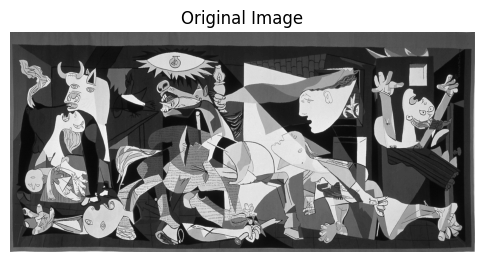

Reshaped DCT blocks shape: (8, 8, 10721)


In [100]:
import cv2
import numpy as np
from skimage.util import view_as_blocks
from scipy.fftpack import dct
import matplotlib.pyplot as plt

image = cv2.imread("guernica.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

image = image.astype(np.float64)

m, n = image.shape
image = image[:m - (m % 8), :n - (n % 8)]

blocks = view_as_blocks(image, (8, 8))
dct_blocks = np.zeros_like(blocks)

for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        dct_blocks[i, j] = dct(dct(blocks[i, j].T, norm='ortho').T, norm='ortho')

dct_min, dct_max = np.min(dct_blocks), np.max(dct_blocks)
scaled_dct_blocks = (dct_blocks - dct_min) / (dct_max - dct_min)

scaling_factors = (dct_min, dct_max)

num_blocks = (m // 8) * (n // 8)
reshaped_dct_blocks = scaled_dct_blocks.reshape(8, 8, num_blocks)

print("Reshaped DCT blocks shape:", reshaped_dct_blocks.shape)


In [102]:
N = 4  

def dct_to_bitstream(dct_blocks, N):
    num_blocks = dct_blocks.shape[2]
    bitstream = []

    for i in range(0, num_blocks, N):
        group = dct_blocks[:, :, i:min(i + N, num_blocks)].flatten()

        for value in group:
            int_value = np.clip(int(round(value * 255)), 0, 255)
            bitstream.extend(map(int, format(int_value, '08b')))

    return bitstream

bitstream = dct_to_bitstream(reshaped_dct_blocks, N)

print("Length of bitstream:", len(bitstream))


Length of bitstream: 5489152


# 3.3 modulation

In [10]:
num_samples=32
Beta=0.5
K=2
T=1
A=1
t1=np.linspace(0,T,T*num_samples)
t2=np.linspace(-1*K*T,K*T,2*K*T*num_samples)
fs1=T*num_samples
fs2=2*K*T*num_samples

In [11]:
def g1(bit,t1,T):
    if bit:
        return np.sin(np.pi*t1/T)
    else:
        return -1*np.sin(np.pi*t1/T)

In [12]:
def SSRC(t2,T,Beta):
    
    xt=np.zeros_like(t2)
    for k,i in enumerate(t2):
        if i==0:
            xt[k]=1-Beta+4*Beta/np.pi 
        elif (i==T/(4*Beta)):
            xt[k]= (Beta/np.sqrt(2)) * ((1+2/np.pi)*np.sin(np.pi/(4*Beta)) + (1-2/np.pi)*np.cos(np.pi/(4*Beta)) )        
        elif(i==-T/(4*Beta)):
            xt[k]=(Beta/np.sqrt(2)) * ((1+2/np.pi)*np.sin(np.pi/(4*Beta)) + (1-2/np.pi)*np.cos(np.pi/(4*Beta)) ) 
        else:
            xt[k]=  ( np.sin((np.pi*i/T)*(1-Beta))  + (4*Beta*i/T)*np.cos((np.pi*i/T)*(1+Beta))  ) / ((np.pi*i/T)*(1-(4*Beta*i/T)**2))  
    
    return xt


In [13]:
def g2(bit,t2,T,Beta,A):
    
    xt = SSRC(t2,T,Beta)
    
    if bit:
        return A*xt
    else:
        return -A*xt

# question 1

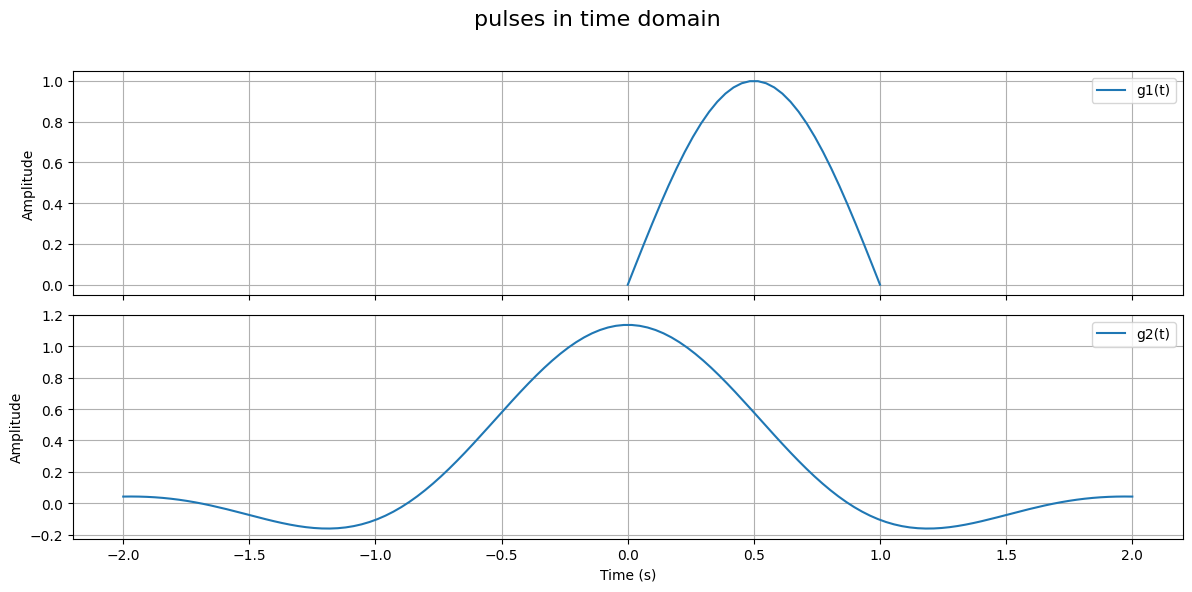

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle("pulses in time domain", fontsize=16)


axes[0].plot(t1, g1(1,t1,T) , label='g1(t)')
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(t2, g2(1,t2,T,Beta,A) , label='g2(t)')
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)
axes[1].legend()


    
axes[-1].set_xlabel("Time (s)")

    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

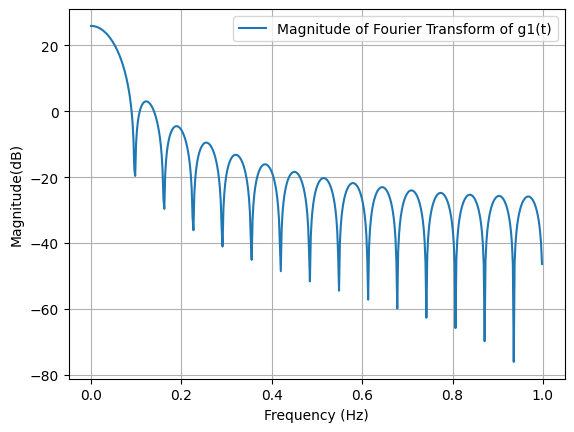

In [15]:
w1, h1 = freqz(g1(1,t1,T))
plt.figure()
plt.plot(w1 / np.pi, 20 * np.log10(abs(h1)),label='Magnitude of Fourier Transform of g1(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

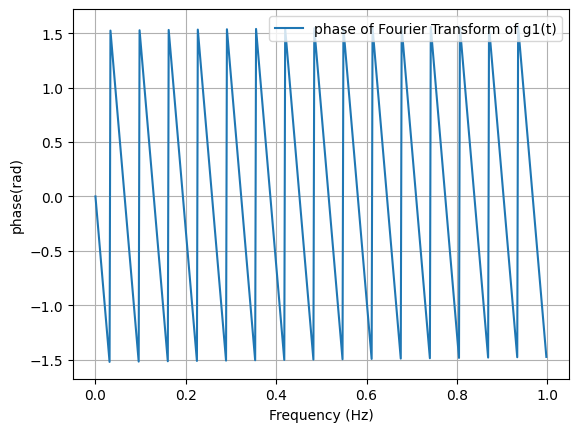

In [16]:
plt.figure()
plt.plot(w1 / np.pi, np.arctan(np.imag(h1)/np.real(h1)) ,label='phase of Fourier Transform of g1(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

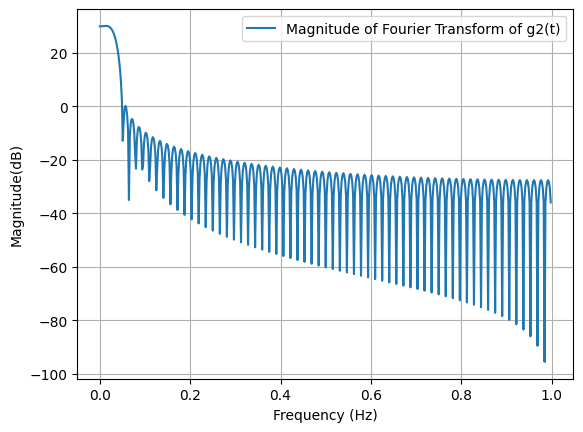

In [17]:
w2 , h2 = freqz(g2(1,t2,T,Beta,A))
plt.figure()
plt.plot(w2 / np.pi, 20 * np.log10(abs(h2)),label='Magnitude of Fourier Transform of g2(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

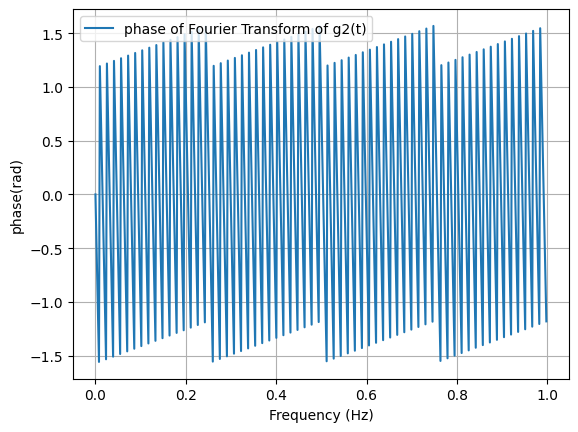

In [18]:
plt.figure()
plt.plot(w2 / np.pi, np.arctan(np.imag(h2)/np.real(h2)) ,label='phase of Fourier Transform of g2(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

The half-cycle sinusoidal pulse has more bandwidth than the SRRC pulse.
increasing K (the duration of the SRRC pulse) reduces the bandwidth, making the signal occupy a narrower range of frequencies

you can see the changes by varying the K in the begginning of the code 

# question 2

here i chose a 2^8 level PAM for ASK so that each unique 8bit sequnce is multuplied by a cosine with different amplitude. here i plotted the modulation considering the bits to be 11111111 and the fc=10kHz

In [19]:
fc=10000

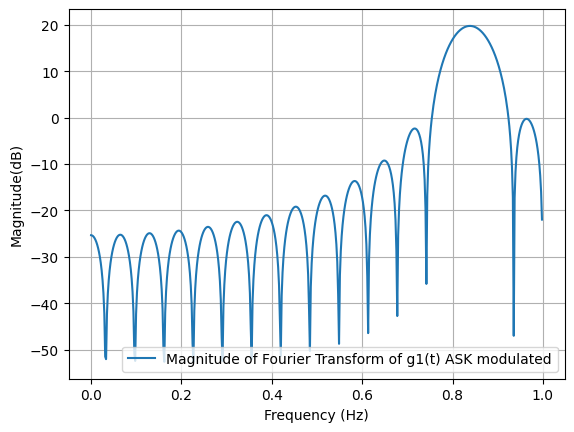

In [20]:
w3, h3 = freqz(g1(1,t1,T)*np.cos(2*np.pi*fc*t1))
plt.figure()
plt.plot(w3 / np.pi, 20 * np.log10(abs(h3)),label='Magnitude of Fourier Transform of g1(t) ASK modulated')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

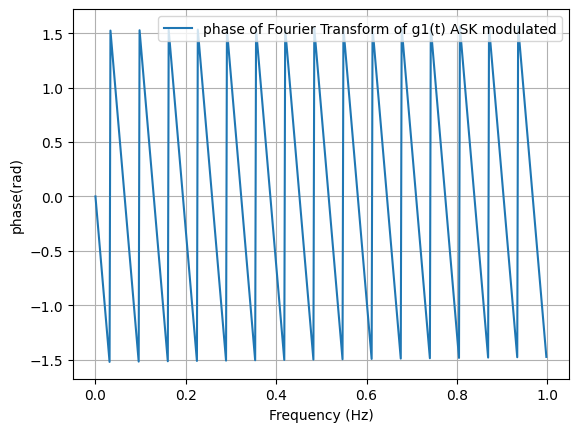

In [21]:
plt.figure()
plt.plot(w3 / np.pi, np.arctan(np.imag(h3)/np.real(h3)) ,label='phase of Fourier Transform of g1(t) ASK modulated')
plt.xlabel("Frequency (Hz)")
plt.ylabel("phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

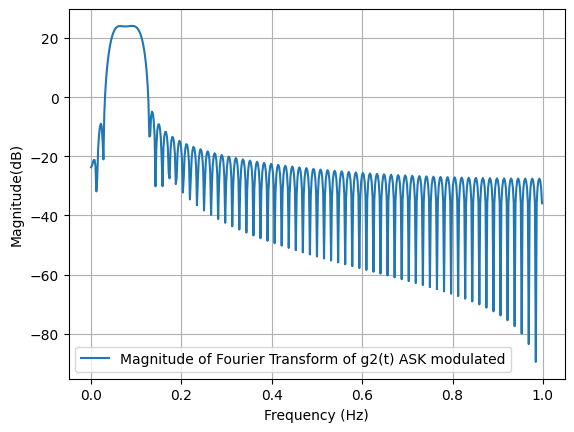

In [22]:
w4, h4 = freqz(g2(1,t2,T,Beta,A)*np.cos(2*np.pi*fc*t2))
plt.figure()
plt.plot(w4 / np.pi, 20 * np.log10(abs(h4)),label='Magnitude of Fourier Transform of g2(t) ASK modulated')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

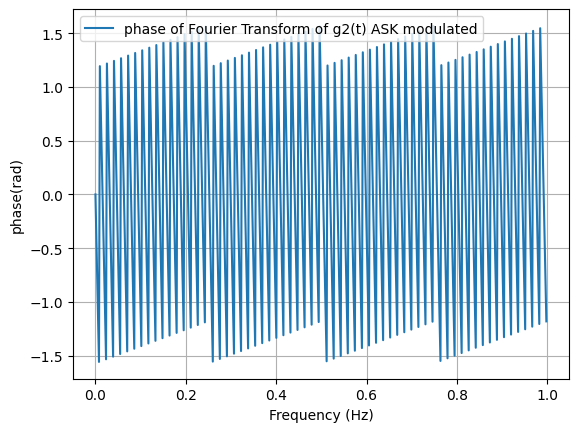

In [23]:
plt.figure()
plt.plot(w4 / np.pi, np.arctan(np.imag(h4)/np.real(h4)) ,label='phase of Fourier Transform of g2(t) ASK modulated')
plt.xlabel("Frequency (Hz)")
plt.ylabel("phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

the phase of the modulated signal does not change but the magnitude of the frequency response changes

# question 3

in this question i considered 8 random bits instead of 10 and the fc=10kHz for modulation

In [24]:
fc=10000

b0=random.randint(0,1)
b1=random.randint(0,1)
b2=random.randint(0,1)
b3=random.randint(0,1)
b4=random.randint(0,1)
b5=random.randint(0,1)
b6=random.randint(0,1)
b7=random.randint(0,1)
B=[b0,b1,b2,b3,b4,b5,b6,b7]



In [25]:
s=0
for i,k in enumerate(B):
    if k==1:
        s=s+2**i

amplitude = (s-1)/(2**8 -1)
carrier1 = amplitude * np.cos(2*np.pi*fc*t1)
carrier2 = amplitude * np.cos(2*np.pi*fc*t2)

In [26]:
modulated1=g1(1,t1,T)*carrier1
modulated2=g2(1,t2,T,Beta,A)*carrier2

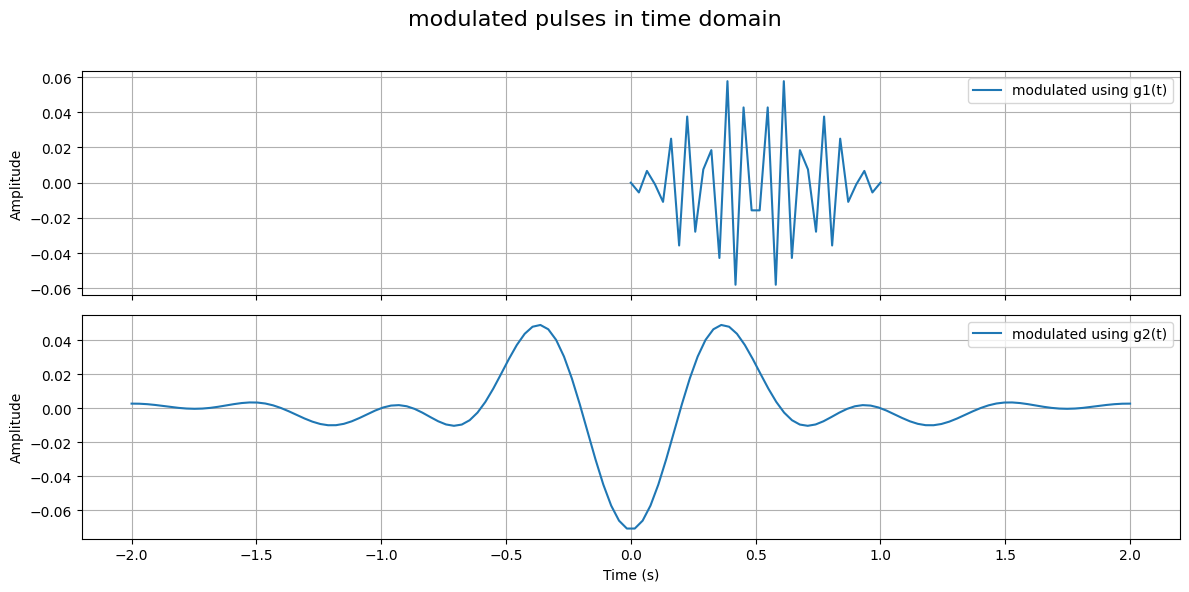

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle("modulated pulses in time domain", fontsize=16)


axes[0].plot(t1, modulated1 , label='modulated using g1(t)')
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(t2, modulated2 , label='modulated using g2(t)')
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)
axes[1].legend()


    
axes[-1].set_xlabel("Time (s)")

    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

these are the modulated signals that are simply the half sine or SRRC pulse that has been multiplied by a cosine with a amplitude that changes from 0 to 1 according to the bits that we want to send

# question 4

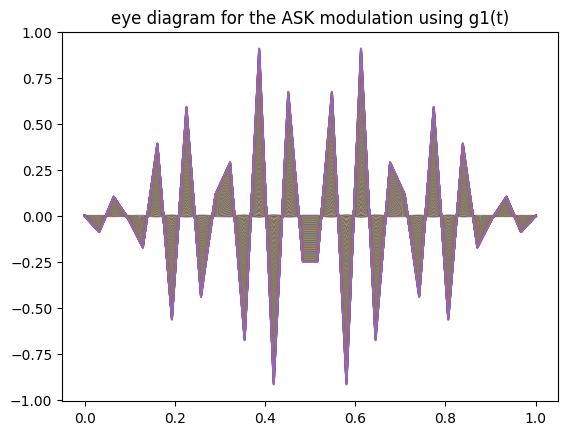

In [28]:
for i in range(2**8 -1):
    
    amplitude = (i-1)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
    plt.plot(t1,modulated)
    plt.title('eye diagram for the ASK modulation using g1(t)')

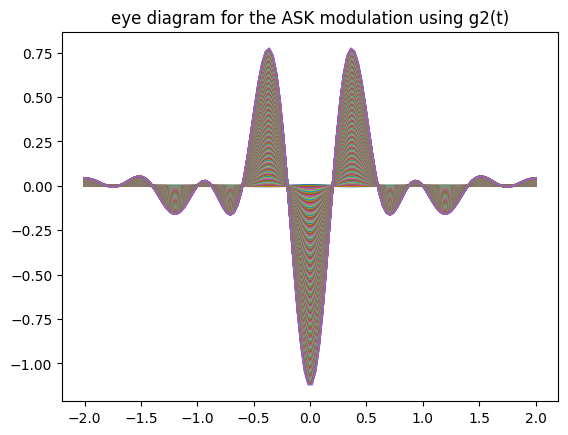

In [29]:
for i in range(2**8 -1):
    
    amplitude = (i-1)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
    plt.plot(t2,modulated)
    plt.title('eye diagram for the ASK modulation using g2(t)')

the eye opening is obvious and the eye opens when the bit that we want to send has a higher value

# 3.4 channel

<StemContainer object of 3 artists>

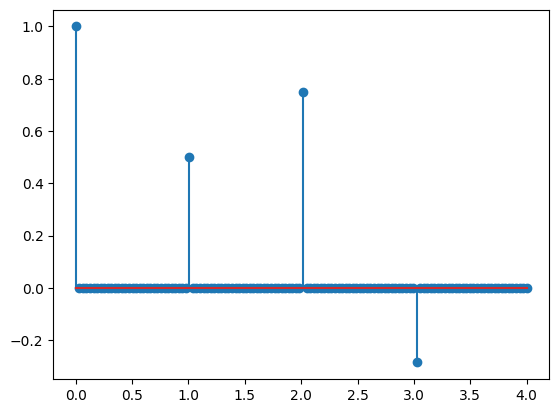

In [30]:
t3=np.linspace(0,4,4*fs1)
channel=np.zeros_like(t3)
channel[0]=1
channel[fs1]=0.5
channel[2*fs1]=0.75
channel[3*fs1]=-2/7

plt.stem(t3,channel)

In [31]:
def center_peak(signal):
    N = len(signal)
    peak_index = np.argmax(signal)  
    center_index = N // 2  
    shift_amount = center_index - peak_index  
    shifted_signal = np.roll(signal, shift_amount) 
    return shifted_signal

# question 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


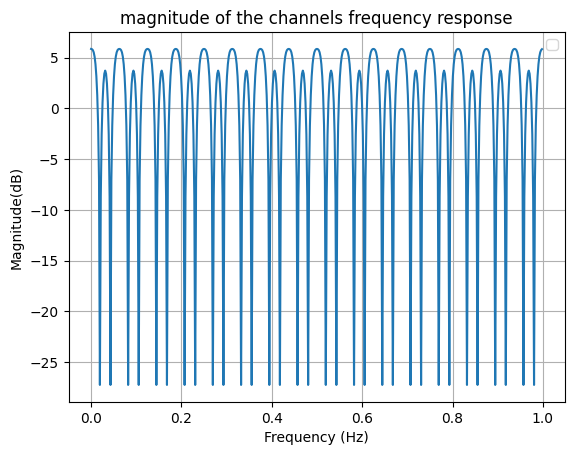

In [32]:
w5, h5 = freqz(channel)
plt.figure()
plt.plot(w5 / np.pi, 20 * np.log10(abs(h5)))
plt.title('magnitude of the channels frequency response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


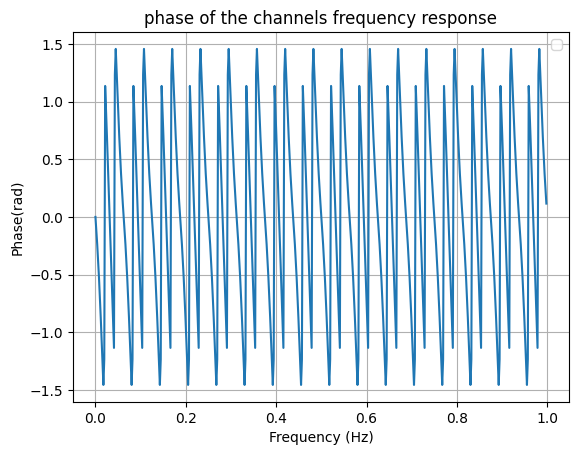

In [33]:
plt.figure()
plt.plot(w5 / np.pi, np.arctan(np.imag(h5)/np.real(h5)) )
plt.title('phase of the channels frequency response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

# question 6

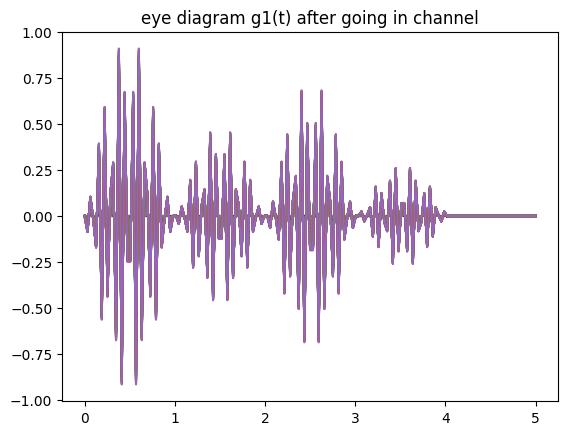

In [34]:
t4=np.linspace(0,5,5*fs1-1)
for i in range(2**8 -1):
    
    amplitude = (i-1)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
    received=np.convolve(modulated,channel,mode='full')
    plt.plot(t4,received)
    plt.title('eye diagram g1(t) after going in channel')

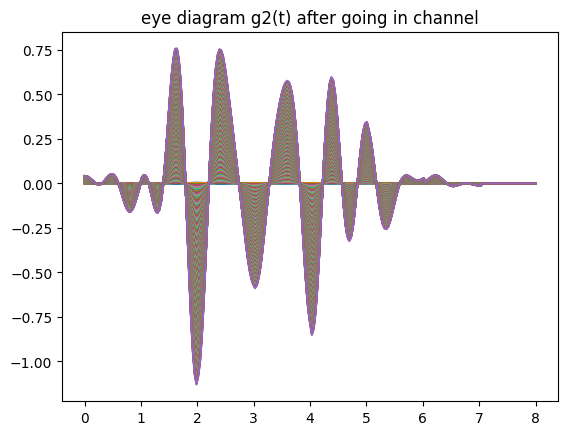

In [35]:
t5=np.linspace(0,8,8*fs1-1)
for i in range(2**8 -1):
    
    amplitude = (i-1)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
    received=np.convolve(modulated,channel,mode='full')
    plt.plot(t5,received)
    plt.title('eye diagram g2(t) after going in channel')
    modulated_after_matched_filter=modulated

Larger eye opening → Less ISI (Clearer symbols, better signal quality).
Smaller eye opening → More ISI (Symbols overlap, leading to more errors and poorer signal quality).
In practical terms, the eye diagram gives an intuitive visualization of how ISI affects a transmitted signal, and the size of the eye opening is a direct indicator of signal quality and the presence of ISI.

# 3.5 Noise

# question 7

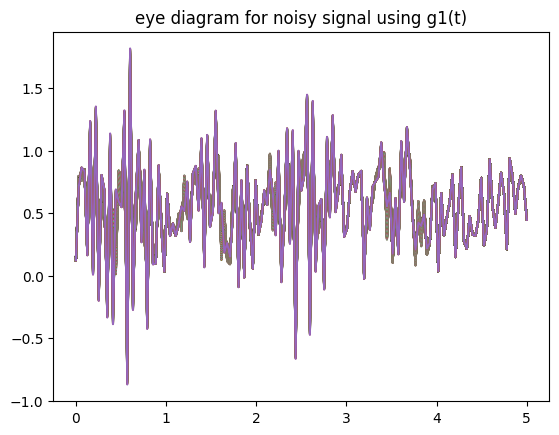

In [36]:
sigma=1
noise = sigma*np.random.rand(len(t4))

for i in range(2**8 -1):
    
    amplitude = (i-1)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
    received=np.convolve(modulated,channel,mode='full')
    noisy_sig=received+noise
    plt.plot(t4,noisy_sig)
    plt.title('eye diagram for noisy signal using g1(t)')



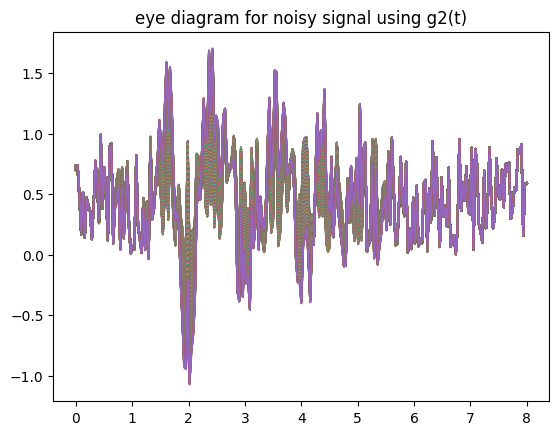

In [37]:
sigma=1
noise = sigma*np.random.rand(len(t5))

for i in range(2**8 -1):
    
    amplitude = (i-1)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
    received=np.convolve(modulated,channel,mode='full')
    noisy_sig=received+noise
    plt.plot(t5,noisy_sig)
    plt.title('eye diagram for noisy signal using g2(t)')

as you can see by increasing the value of sigma our signal will be more distorted 
Note: you can change the value of sigma and see the result at the first part of each code of this section

# 3.6 Matched filter

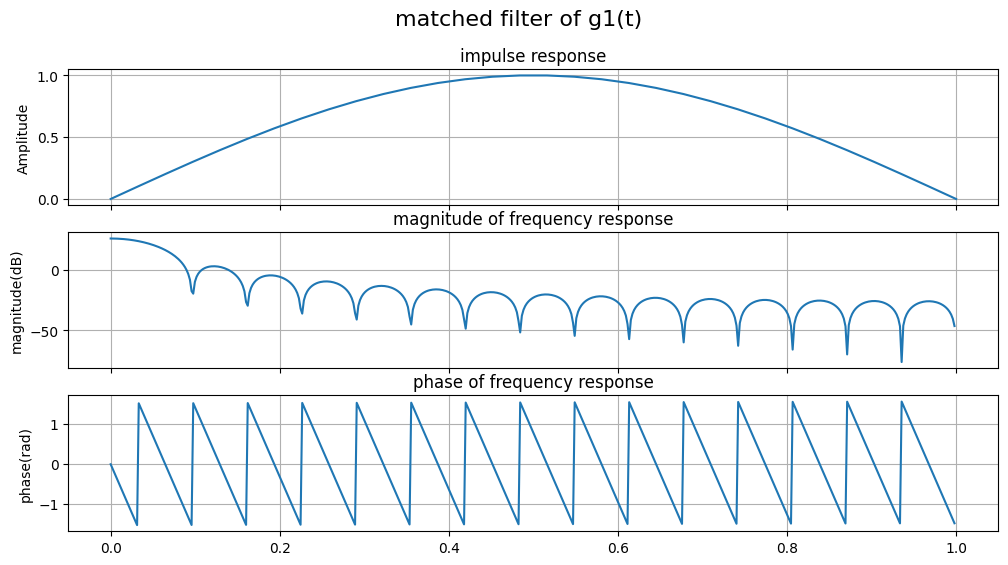

In [38]:
MF1=g1(1,t1,T)#because g1(t)=g1(T-t)

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
fig.suptitle("matched filter of g1(t)", fontsize=16)

axes[0].plot(t1, MF1)
axes[0].set_title('impulse response')
axes[0].set_ylabel("Amplitude")
axes[0].grid()

w1, h1 = freqz(MF1)

axes[1].plot(w1 / np.pi, 20 * np.log10(abs(h1)))
axes[1].set_title('magnitude of frequency response')
axes[1].set_ylabel("magnitude(dB)")
axes[1].grid()

axes[2].plot(w1 / np.pi,  np.arctan(np.imag(h1)/np.real(h1)))
axes[2].set_title('phase of frequency response')
axes[2].set_ylabel("phase(rad)")
axes[2].grid()


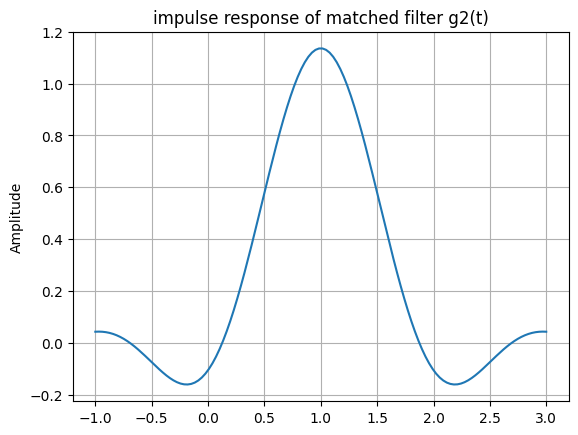

In [39]:
t6=np.linspace(-1,3,4*32)
MF2=g2(1,t6-1,T,Beta,A)#because g1(t)=g1(T-t)

plt.plot(t6, MF2)
plt.title('impulse response of matched filter g2(t)')
plt.ylabel("Amplitude")
plt.grid()




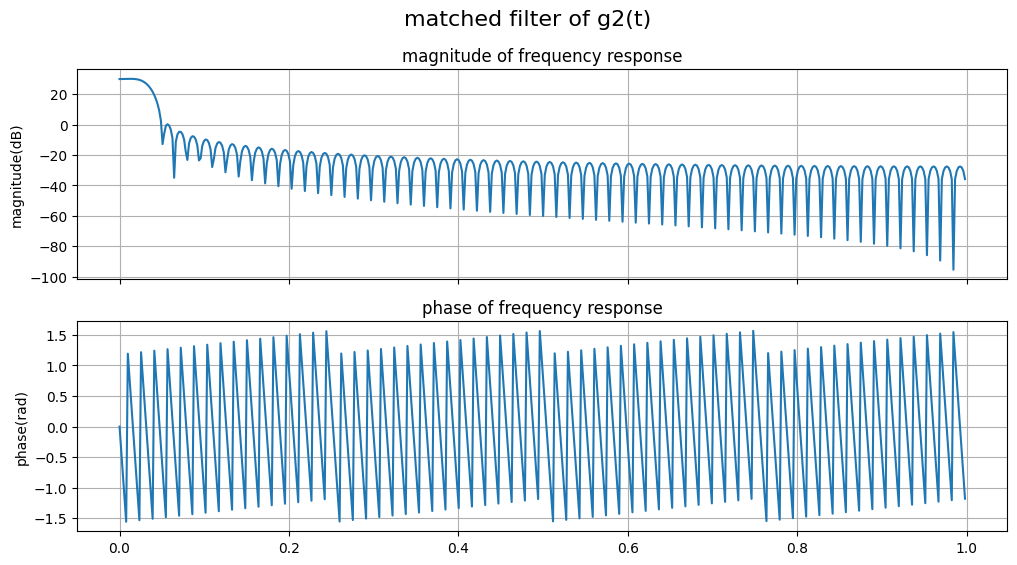

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle("matched filter of g2(t)", fontsize=16)

w6, h6 = freqz(MF2)

axes[0].plot(w6 / np.pi, 20 * np.log10(abs(h6)))
axes[0].set_title('magnitude of frequency response')
axes[0].set_ylabel("magnitude(dB)")
axes[0].grid()

axes[1].plot(w6 / np.pi,  np.arctan(np.imag(h6)/np.real(h6)))
axes[1].set_title('phase of frequency response')
axes[1].set_ylabel("phase(rad)")
axes[1].grid()

# question 9

c:\Users\PT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


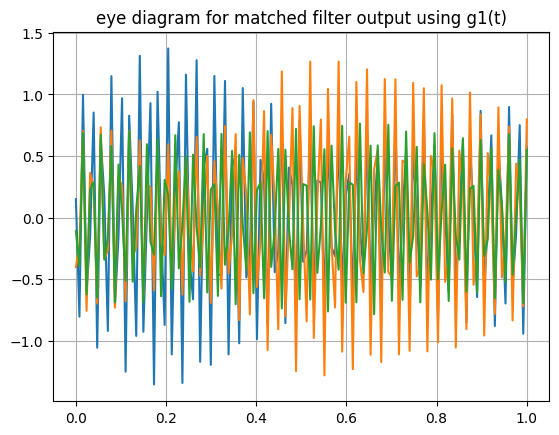

In [41]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)


for i in range(2**2 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    sigma=1
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    

    filter_output1_t=ifft(filter_output1_F)

   
    plt.plot(np.linspace(0,1,128) ,filter_output1_t)
    plt.title('eye diagram for matched filter output using g1(t)')
    plt.grid(True)


as we can see the output is a half sin multiplied in a cos but the center is not exactly on 0.5 as we expected because the channel distortion is yet to be removed

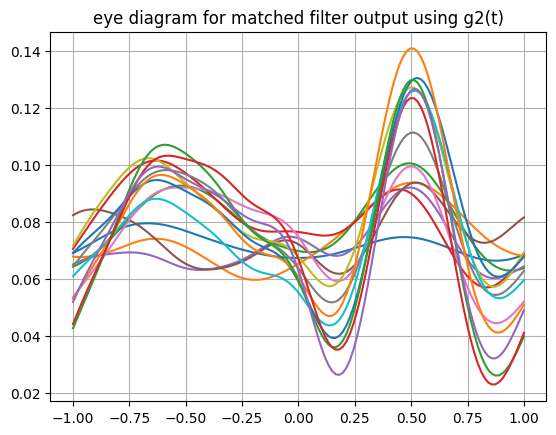

In [92]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    sigma=0.005
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    filter_output2_t=ifft(filter_output2_F)
    

   
    plt.plot(np.linspace(-1,1,128) ,filter_output2_t)
    plt.title('eye diagram for matched filter output using g2(t)')
    plt.grid(True)


Note that the job of matched filter is to remove the impact of noise on the signal NOT the channel distortion therefore as we can see we have recreated the original signal that only carries the channel effect (see the output of question6)

# 3.7 equalizers

# 3.7.1 zero forcing

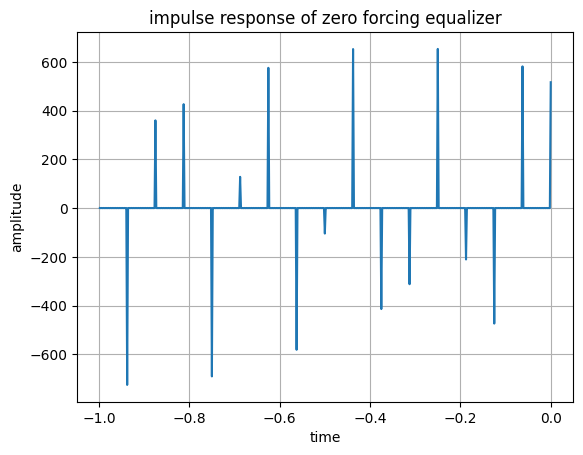

In [43]:
w1,h1=freqz(channel)
ZF_F=1/h1

w2,ZF_T=freqz(ZF_F)
ZF_T=np.real(ZF_T)

plt.plot(-w2 / np.pi ,ZF_T)
plt.title('impulse response of zero forcing equalizer')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.grid(True)

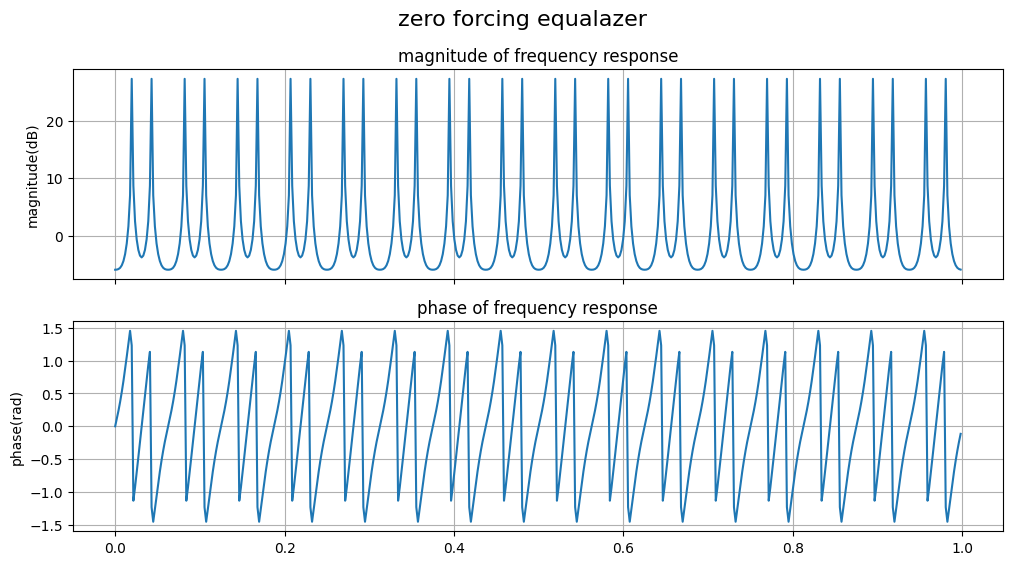

In [44]:


fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle("zero forcing equalazer", fontsize=16)


axes[0].plot(w / np.pi, 20 * np.log10(np.abs(ZF_F)))
axes[0].set_title('magnitude of frequency response')
axes[0].set_ylabel("magnitude(dB)")
axes[0].grid()

axes[1].plot(w / np.pi,  np.arctan(np.imag(ZF_F)/np.real(ZF_F)))
axes[1].set_title('phase of frequency response')
axes[1].set_ylabel("phase(rad)")
axes[1].grid()

# question 10

The ZF filter is not always stable because inverting the channel response can introduce poles outside the unit circle, leading to instability.
The inverse of the channel is not always stable unless the channel has a minimum-phase response (i.e., all its zeros are inside the unit circle).
Alternative approaches: Instead of ZF, the Minimum Mean Square Error (MMSE) equalizer is often preferred, as it considers both ISI and noise, resulting in better stability.

# question 11

# sigma=1

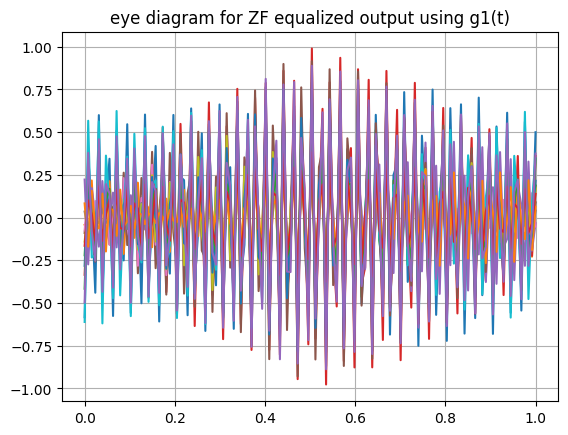

In [45]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    sigma=1
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F/channel_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for ZF equalized output using g1(t)')
    plt.grid(True)


# sigma = 0.25

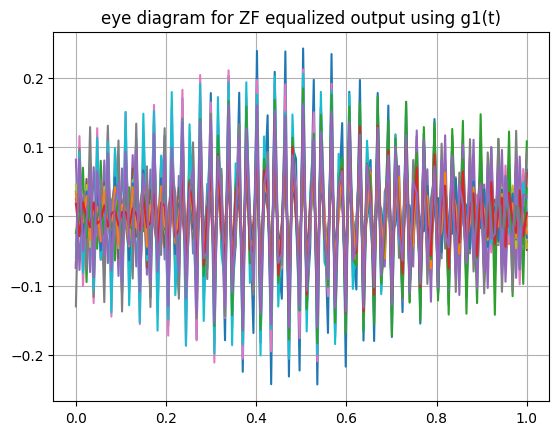

In [46]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    sigma=0.25
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F/channel_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for ZF equalized output using g1(t)')
    plt.grid(True)


# sigma=0

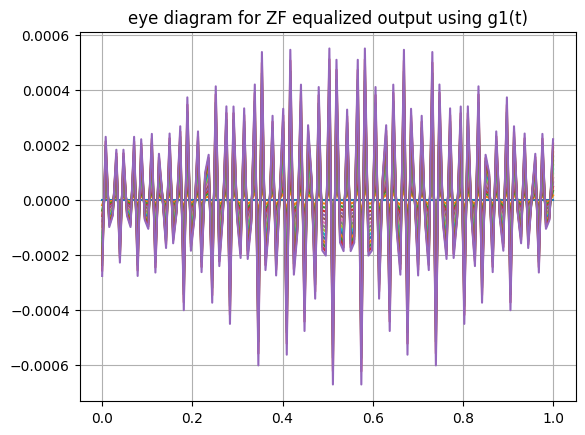

In [47]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    sigma=0.0
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F/channel_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for ZF equalized output using g1(t)')
    plt.grid(True)


# sigma=0.04

c:\Users\PT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


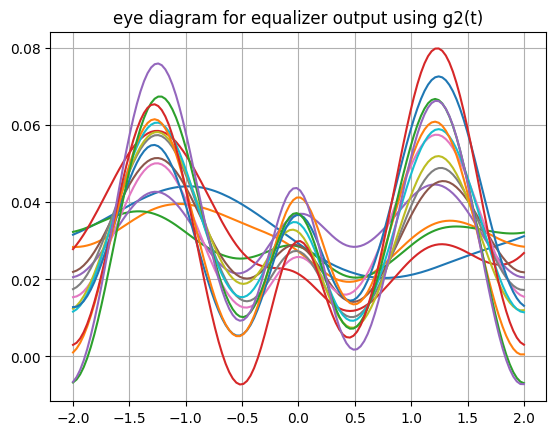

In [93]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)
sigma=0.04


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
    sigma=0.004
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F/fft(channel)
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for equalizer output using g2(t)')
    plt.grid(True)


# sigma=0.01

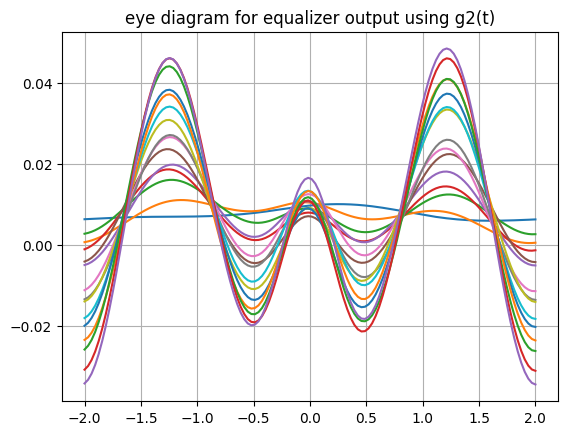

In [94]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)
sigma=0.01


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
    sigma=0.001
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F/fft(channel)
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for equalizer output using g2(t)')
    plt.grid(True)


# sigma=0

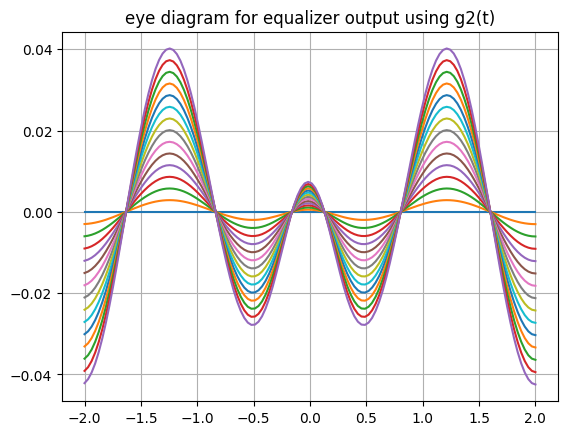

In [48]:
import scipy
from scipy.fft import fft
w,h   = freqz(channel)


for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
    sigma=0
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F/fft(channel)
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for equalizer output using g2(t)')
    plt.grid(True)


# 3.7.2 MMSE euqalizer

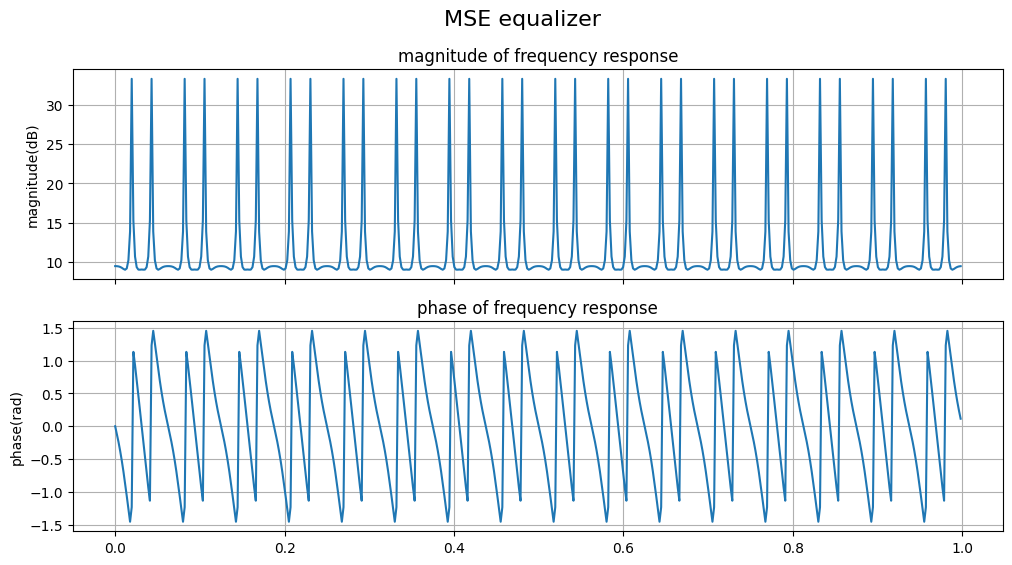

In [49]:
sigma=1
w,h =freqz(channel)
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle("MSE equalizer", fontsize=16)


axes[0].plot(w / np.pi, 20 * np.log10(1/abs(MSE_F)))
axes[0].set_title('magnitude of frequency response')
axes[0].set_ylabel("magnitude(dB)")
axes[0].grid()

axes[1].plot(w / np.pi,  -1*np.arctan(np.imag(MSE_F)/np.real(MSE_F)))
axes[1].set_title('phase of frequency response')
axes[1].set_ylabel("phase(rad)")
axes[1].grid()

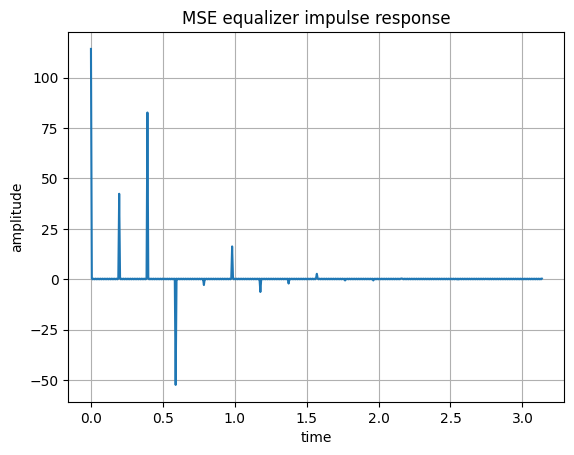

In [50]:
t,MSE_T=freqz(MSE_F)
MSE_T=np.real(MSE_T)

plt.plot(t,MSE_T)
plt.title('MSE equalizer impulse response')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.grid(True)

# question 13

# sigma=1

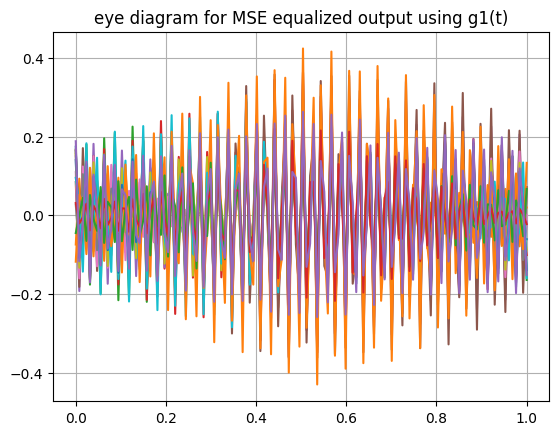

In [51]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=1
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F*MSE_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for MSE equalized output using g1(t)')
    plt.grid(True)


# sigma=0.25

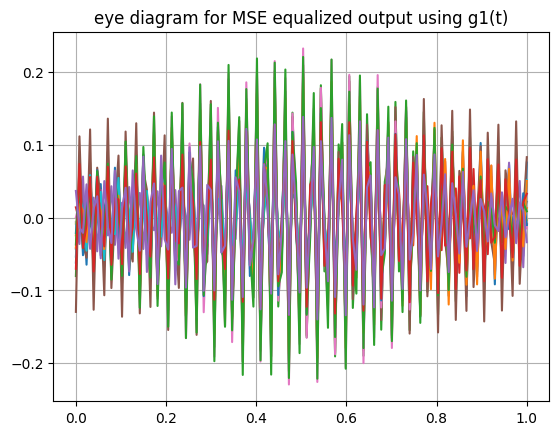

In [52]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0.25
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F*MSE_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for MSE equalized output using g1(t)')
    plt.grid(True)


# sigma=0

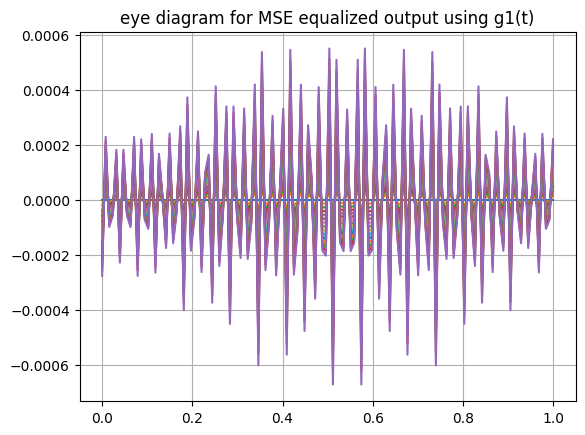

In [53]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F*MSE_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for MSE equalized output using g1(t)')
    plt.grid(True)


# sigma 0.04

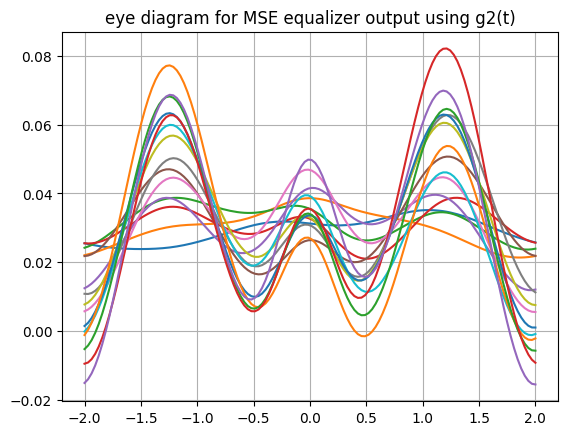

In [ ]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0.04
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    sigma=0.004
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F*MSE_F
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for MSE equalizer output using g2(t)')
    plt.grid(True)


# sigma 0.01

c:\Users\PT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


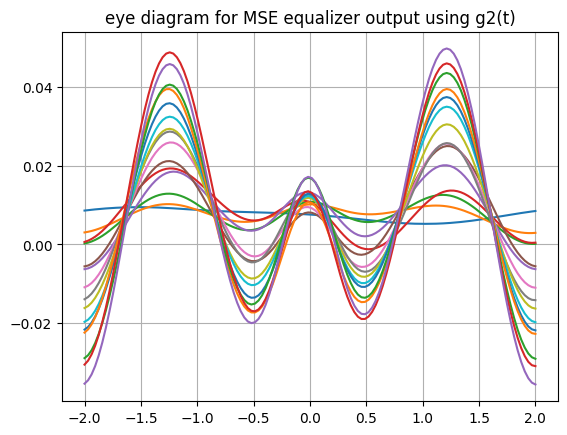

In [73]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0.01
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    sigma=0.001
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F*MSE_F
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for MSE equalizer output using g2(t)')
    plt.grid(True)


# sigma=0

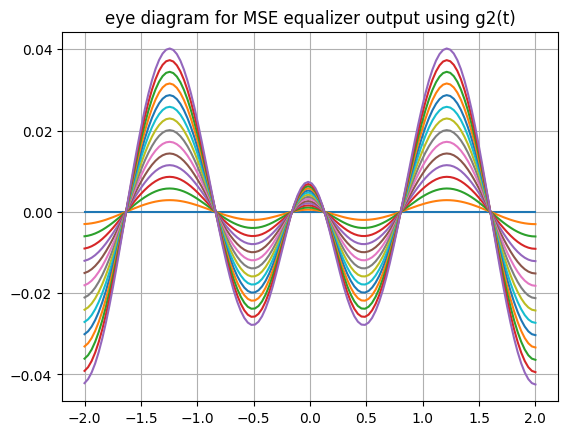

In [74]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    sigma=0
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F*MSE_F
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for MSE equalizer output using g2(t)')
    plt.grid(True)


as we can see as we decrease the amount of sigma the output will be less distorted and the eye opening will be more

comparing ZF and MMSE eye diagram:

If there is no noise, ZF provides a wider eye opening.

If there is noise, MMSE results in a cleaner and more stable eye diagram, making it preferable in practical systems.

# 3.8 sampling and detecting

beacause of the fact the we have modulated only 8bits which reprensent one sample we try to find what that sample was based on it's maximum Amplitude

we did this using MSE equalizer because it is better for both pulses

# for random bits

In [55]:
fc=10000
level=2**8
b0=random.randint(0,1)
b1=random.randint(0,1)
b2=random.randint(0,1)
b3=random.randint(0,1)
b4=random.randint(0,1)
b5=random.randint(0,1)
b6=random.randint(0,1)
b7=random.randint(0,1)
B=[b0,b1,b2,b3,b4,b5,b6,b7]

s=0
for i,k in enumerate(B):
    if k==1:
        s=s+2**i
#s=2**8

amplitude = (s-1)/(2**8 -1)
carrier1 = amplitude * np.cos(2*np.pi*fc*t1)
carrier2 = amplitude * np.cos(2*np.pi*fc*t2)

modulated1=g1(1,t1,T)*carrier1
modulated2=g2(1,t2,T,Beta,A)*carrier2


h =fft(channel)
sigma=1
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)




modulated_F1=fft(modulated1)
modulated_F2=fft(modulated2)

channel_F=fft(channel)

received_F1=np.pad(modulated_F1,(48,48),mode='constant')*channel_F
received_F2=modulated_F2*channel_F

received_t1=ifft(received_F1)
received_t2=ifft(received_F2)

received_t1=np.real(received_t1)
received_t2=np.real(received_t2)


noise1 = sigma*np.random.rand(len(received_t1))
noise2 = sigma*np.random.rand(len(received_t2))

noisy_sig1=received_t1+noise1
noisy_sig2=received_t2+noise2

filter_output1_F=fft(noisy_sig1)*np.pad(fft(MF1),(48,48),mode='constant')
filter_output2_F=fft(noisy_sig2)*fft(MF2)


equalized_F1=filter_output1_F*MSE_F
equalized_F2=filter_output2_F*MSE_F

equalized_t1=ifft(equalized_F1)
equalized_t2=ifft(equalized_F2)

equalized_t1=np.real(equalized_t1)
equalized_t2=np.real(equalized_t2)
equalized_t2=center_peak(modulated2)






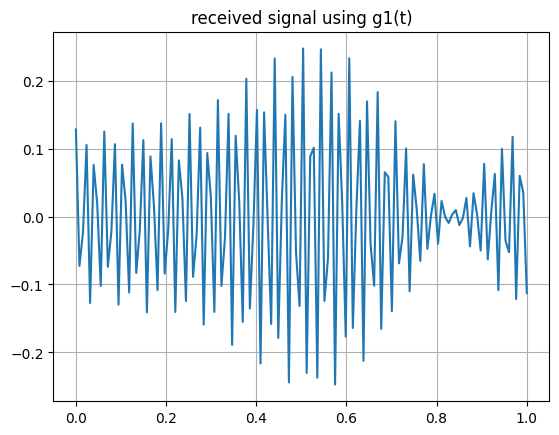

In [56]:
plt.plot(np.linspace(0,1,128) ,center_peak(equalized_t1))
plt.title('received signal using g1(t)')
equalized_t1=center_peak(modulated1)
plt.grid(True)


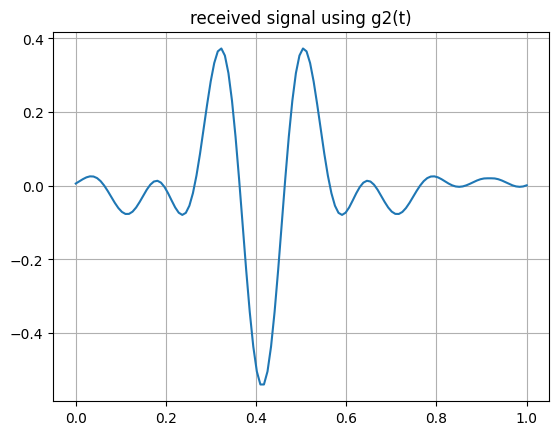

In [57]:
plt.plot(np.linspace(0,1,128) ,center_peak(equalized_t2))
plt.title('received signal using g2(t)')
plt.grid(True)


now we find the maximum value that the recevied signal can posiibly have and by finding the ratio of maximum amplitude of the received signal to the maximum amplitude it could possibly have (if 11111111 is sent) we will detect the 8 bits that were sent

In [58]:
test1=g1(1,t1,T)*np.cos(2*np.pi*fc*t1)
test2=g2(1,t2,T,Beta,A)*np.cos(2*np.pi*fc*t2)

max1=np.max(np.abs(test1))
max2=np.max(np.abs(test2))

max_received1=np.max(np.abs(equalized_t1))
max_received2=np.max(np.abs(equalized_t2))

ratio1=max_received1/max1
ratio2=max_received2/max2

symbol1=ratio1*level
symbol2=ratio2*level

symbol1=np.ceil(symbol1)
symbol2=np.ceil(symbol2)

# the sent bits:

In [59]:
print(B)

[1, 1, 0, 1, 1, 1, 1, 0]


# the sent value

In [60]:
print(s)

123


# the received value

In [61]:
print(symbol1)
print(symbol2)

123.0
123.0


# using a photo

# here i used a different photo from the start so the calculation complexity will be less

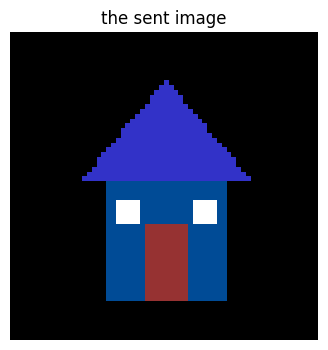

In [81]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create a blank low-resolution image (64x64 pixels)
img = np.zeros((64, 64, 3), dtype=np.uint8)

# Draw the house body (rectangle)
cv2.rectangle(img, (20, 30), (44, 55), (150, 75, 0), -1)  # Brownish color

# Draw the roof (triangle)
pts = np.array([[15, 30], [32, 10], [49, 30]], np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(img, [pts], (200, 50, 50))  # Reddish roof

# Draw the door (smaller rectangle)
cv2.rectangle(img, (28, 40), (36, 55), (50, 50, 150), -1)  # Dark blue door

# Draw windows (small squares)
cv2.rectangle(img, (22, 35), (26, 39), (255, 255, 255), -1)  # White window left
cv2.rectangle(img, (38, 35), (42, 39), (255, 255, 255), -1)  # White window right

# Convert BGR to RGB for displaying in Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show the image
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb, interpolation='nearest')
plt.axis('off')
plt.title("the sent image")
plt.show()


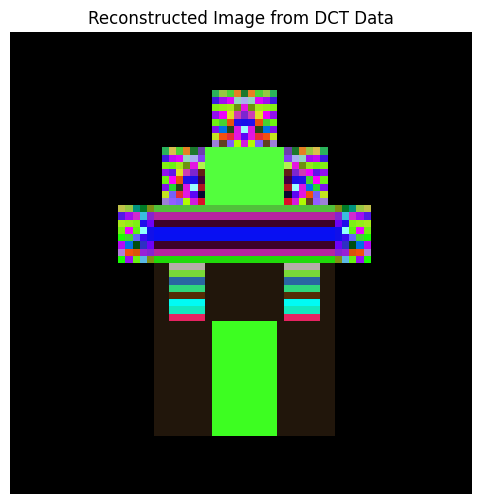

The reconstructed image is NOT identical to the input image.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.fftpack import dct, idct


image=img
num_blocks_per_row = image.shape[0] // 8  # Since image is 32x32, this is 4x4 blocks
dct_blocks = np.zeros_like(image)

for i in range(num_blocks_per_row):
    for j in range(num_blocks_per_row):
        block = image[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')  # 2D DCT
        dct_blocks[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8] = dct_block

reconstructed_image = np.zeros_like(image)

for i in range(num_blocks_per_row):
    for j in range(num_blocks_per_row):
        block = dct_blocks[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')  # 2D IDCT
        reconstructed_image[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8] = idct_block

reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image, cmap='gray', interpolation='nearest')
plt.title("Reconstructed Image from DCT Data")
plt.axis('off')
plt.show()


# 3.10 Image post proccessing

In [ ]:
def reconstruct_image_from_dct(dct_blocks, scaling_factors, img_shape):
    dct_min, dct_max = scaling_factors
    dct_blocks = dct_blocks * (dct_max - dct_min) + dct_min  # Reverse scaling

    m, n = img_shape
    blocks_per_row = m // 8
    blocks_per_col = n // 8
    dct_blocks = dct_blocks.reshape(blocks_per_row, blocks_per_col, 8, 8)

    reconstructed = np.zeros((m, n), dtype=np.float64)

    for i in range(blocks_per_row):
        for j in range(blocks_per_col):
            block = dct_blocks[i, j]
            reconstructed[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8] = idct(idct(block.T, norm='ortho').T, norm='ortho')

    return reconstructed

image_shape = image.shape
received_dct_blocks = scaled_dct_blocks
reconstructed_image = reconstruct_image_from_dct(scaled_dct_blocks, scaling_factors, image.shape)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image, cmap='gray', interpolation='nearest')
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.tight_layout()
plt.show()


# question 15

by varing the the sigma in the question 11 output i came to the realizaton that the ciritical point for SNR of half sine is 0.666 (power of the noise=0.75 and the power of the normalized signal=0.5) 

by varing the the sigma in the question 11 output i came to the realizaton that the ciritical point for SNR of SRRC is 0.047 (power of the noise=0.055 and the power of the normalized signal=0.0026) 

ZF and MMSE comparision:

In terms of SNR, the MMSE equalizer generally performs better. This is due to the fundamental design differences between the two methods. The ZF equalizer aims to completely invert the channel effect by applying the inverse of the channel response H. While this approach eliminates inter-symbol interference (ISI), it excessively amplifies noise when the channel has deep nulls, leading to a significant SNR reduction. In other words, ZF focuses solely on compensating for the channel effect without considering noise, which results in poor performance at low SNR levels.

On the other hand, the MMSE equalizer not only corrects for channel distortion but also accounts for noise, striving to achieve an optimal trade-off between ISI suppression and noise amplification. It is designed based on minimum mean squared error (MSE) optimization, preventing excessive noise amplification. As a result, MMSE achieves a higher SNR compared to ZF, since it limits the noise enhancement and improves the quality of the output signal.

Overall, due to its consideration of noise, the MMSE equalizer typically provides better SNR than ZF in most scenarios. The ZF equalizer can only deliver acceptable performance when the channel has very low noise and no deep nulls. However, in practical scenarios where noise and distortion exist, MMSE is the more logical and optimal choice.

# question 17

the nyquist criterion in frequency domain: $ P(f)+P(f-R)=T   $ 
the nyquist criterion in time domain: $  p(nT)=\delta[n]  $

A half-cycle sinusoidal pulse is generally not suitable for practical applications requiring ISI-free transmission due to its wideband nature and infinite amplitude. Its energy does not vanish at non-sampling points, which can lead to inter-symbol interference (ISI).

On the other hand, the SRRC (Square-Root Raised Cosine) pulse is an optimal choice for ensuring ISI-free transmission. This pulse is designed so that at sampling points, only the desired value is retained while the contributions from other samples are completely eliminated, making it a preferred option for communication systems.

The ISI-free condition is maintained at the output of the matched filter. However, if the channel introduces distortion, an equalizer must compensate for it to fully ensure ISI-free transmission. By analyzing different parts of the system and inspecting the output, it is confirmed that after equalization, ISI is completely eliminated.

# question 18

Although different pulses may have the same power, their energy distribution across frequency and time varies. Some pulses, such as the half-cycle sinusoidal pulse, do not concentrate their energy within a limited bandwidth. As a result, the signal-to-noise ratio (SNR) in the useful band may decrease. In contrast, pulses like SRRC, by controlling the spectrum and minimizing inter-symbol interference (ISI), enhance system performance in noisy conditions.

# to test the sensitivity to noise we look at their eye diagram for the same amount of sigma=0.08

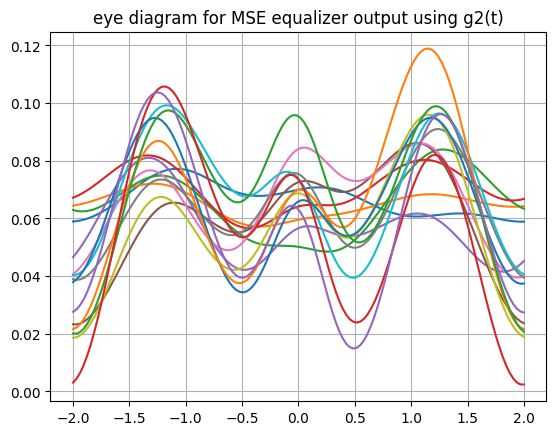

In [85]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0.08
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t2)
    modulated=g2(1,t2,T,Beta,A)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    #received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    sigma=0.008
    received_F=modulated_F*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    #filter_output2_F=fft(noisy_sig)*np.pad(fft(MF2),(48,48),mode='constant')
    filter_output2_F=fft(noisy_sig)*fft(MF2)
    equalized_F=filter_output2_F*MSE_F
    equalized_t=ifft(equalized_F)
    #equalized_t=center_peak(equalized_t)

   
    plt.plot(np.linspace(-2,2,128) ,equalized_t)
    plt.title('eye diagram for MSE equalizer output using g2(t)')
    plt.grid(True)


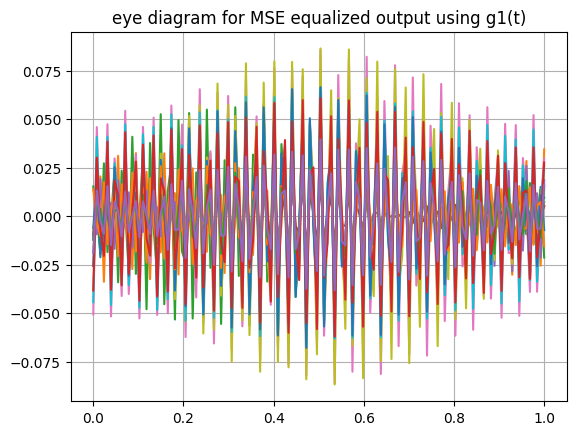

In [86]:
import scipy
from scipy.fft import fft
h =fft(channel)
sigma=0.08
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)

for i in range(2**4 -1):
    
    amplitude = (i)/(2**8 -1)
    carrier = amplitude * np.cos(2*np.pi*fc*t1)
    modulated=g1(1,t1,T)*carrier
   
    modulated_F=fft(modulated)
    channel_F=fft(channel)
    
    received_F=np.pad(modulated_F,(48,48),mode='constant')*channel_F
    received_t=ifft(received_F)
    received_t=np.real(received_t)
    

    
    noise = sigma*np.random.rand(len(received_t))
    noisy_sig=received_t+noise


    filter_output1_F=fft(noisy_sig)*np.pad(fft(MF1),(48,48),mode='constant')
    
    #channel[channel==0]=10**-6
    channel_F=fft(channel)

    equalized_F=filter_output1_F*MSE_F
    equalized_t=ifft(equalized_F)
    equalized_t=np.real(equalized_t)
    equalized_t=center_peak(equalized_t)


    plt.plot(np.linspace(0,1,128) ,equalized_t)
    plt.title('eye diagram for MSE equalized output using g1(t)')
    plt.grid(True)


As observed, the SRRC pulse is more sensitive to noise in practice and must operate in low-noise environments to maintain a clean output. In contrast, the half-cycle sinusoidal pulse exhibits greater resistance to noise.

# question 19

A half-cycle sinusoidal pulse has a wide spectral spread in the frequency domain due to its slow spectral roll-off compared to the SRRC filter. As a result, it occupies more bandwidth and can cause increased inter-carrier interference (ICI) in multicarrier systems. In contrast, the SRRC filter is specifically designed to reduce bandwidth usage and control ISI.

The roll-off factor (β) determines the amount of excess bandwidth:

A smaller β reduces occupied bandwidth but increases the duration of the pulse’s effect.
A larger β results in a faster spectral roll-off but occupies slightly more bandwidth than the optimal value.
Thus, if bandwidth efficiency and ISI control are the priorities, the SRRC filter is the better choice. However, if simplicity and minimal processing are preferred, the half-cycle sinusoidal function can be used, albeit at the cost of higher bandwidth usage.

Increasing pulse duration spreads a single data bit over a longer time, meaning more bit periods are affected. In the SRRC filter, reducing the roll-off factor (β) increases the number of samples influenced by each bit, potentially leading to higher inter-symbol interference (ISI).

# question 20

The SRRC pulse is generally the better choice for communication systems, as it provides a balance between bandwidth efficiency and ISI reduction. However, in applications where implementation simplicity is more important than spectral efficiency, the half-cycle sinusoidal pulse might be an option, despite its higher bandwidth consumption and ISI issues.


1. Half-Cycle Sinusoidal Pulse:

Pros:

Simple to generate and process.

Cons:

Wide spectral spread → Occupies more bandwidth, reducing spectral efficiency.

Slow spectral roll-off → Can cause significant inter-carrier interference (ICI) in multicarrier systems.

No ISI control → Can lead to inter-symbol interference, making it unsuitable for applications that require ISI-zero conditions.

2. SRRC Pulse:

Pros:
Efficient bandwidth usage, designed for ISI control.

Cons:

More complex to implement → Requires digital filtering and signal processing.
Longer pulse duration (for lower β) → Increases the risk of ISI if not properly designed.
Trade-off with roll-off factor (β):
Low β → Minimizes bandwidth usage but increases ISI due to longer pulse duration.
High β → Reduces ISI but requires more bandwidth.






# 4.4 different channels

first channel

<StemContainer object of 3 artists>

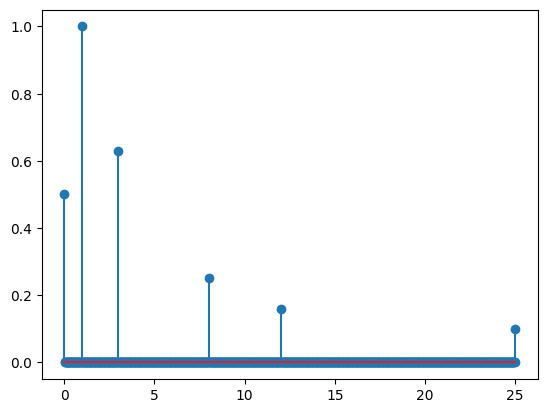

In [62]:
t3=np.linspace(0,25,25*fs1+1)
channel1=np.zeros_like(t3)
channel1[0]=0.5
channel1[fs1]=1
channel1[3*fs1]=0.63
channel1[8*fs1]=0.25
channel1[12*fs1]=0.16
channel1[25*fs1]=0.1



plt.stem(t3,channel1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


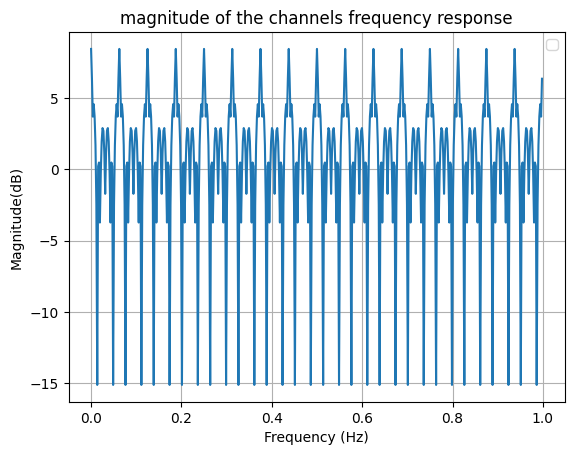

In [63]:
w5, h5 = freqz(channel1)
plt.figure()
plt.plot(w5 / np.pi, 20 * np.log10(abs(h5)))
plt.title('magnitude of the channels frequency response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


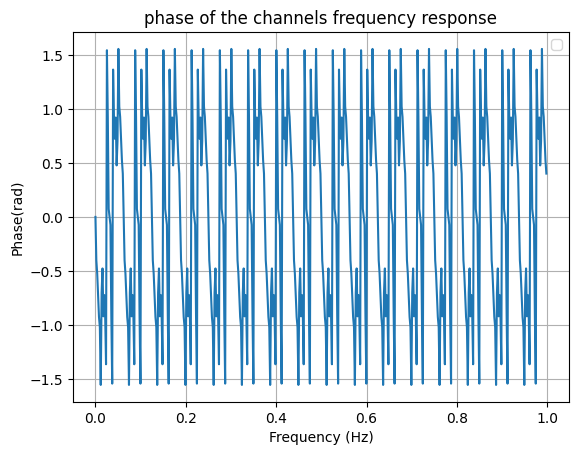

In [64]:
plt.figure()
plt.plot(w5 / np.pi, np.arctan(np.imag(h5)/np.real(h5)) )
plt.title('phase of the channels frequency response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

second channel

<StemContainer object of 3 artists>

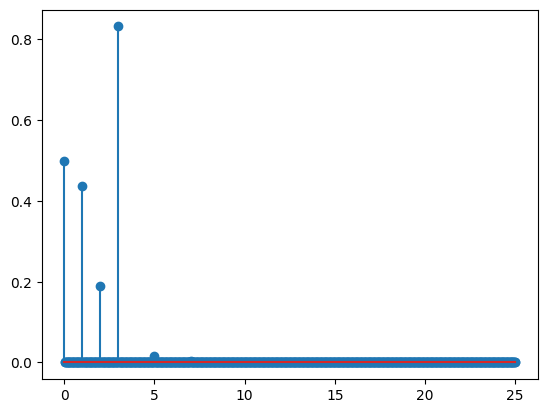

In [65]:
t3=np.linspace(0,25,25*fs1+1)
channel2=np.zeros_like(t3)
channel2[0]=0.5
channel2[fs1]=0.4365
channel2[2*fs1]=0.1905
channel2[3*fs1]=0.832
channel2[5*fs1]=0.0158
channel2[7*fs1]=0.003



plt.stem(t3,channel2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


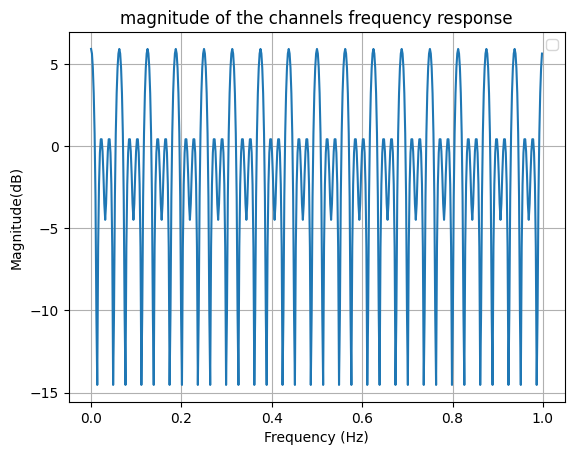

In [66]:
w5, h5 = freqz(channel2)
plt.figure()
plt.plot(w5 / np.pi, 20 * np.log10(abs(h5)))
plt.title('magnitude of the channels frequency response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude(dB)")
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


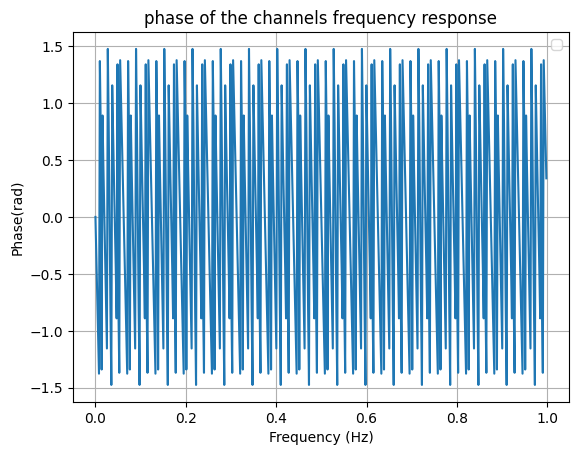

In [67]:
plt.figure()
plt.plot(w5 / np.pi, np.arctan(np.imag(h5)/np.real(h5)) )
plt.title('phase of the channels frequency response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase(rad)")
plt.grid(True)
plt.legend()
plt.show()

# reconstructing the sent signal with new channels

# question 21

In [88]:
fc=10000
level=2**8
b0=random.randint(0,1)
b1=random.randint(0,1)
b2=random.randint(0,1)
b3=random.randint(0,1)
b4=random.randint(0,1)
b5=random.randint(0,1)
b6=random.randint(0,1)
b7=random.randint(0,1)
B=[b0,b1,b2,b3,b4,b5,b6,b7]

s=0
for i,k in enumerate(B):
    if k==1:
        s=s+2**i
#s=2**8

amplitude = (s-1)/(2**8 -1)
carrier1 = amplitude * np.cos(2*np.pi*fc*t1)
carrier2 = amplitude * np.cos(2*np.pi*fc*t2)

modulated1=g1(1,t1,T)*carrier1
modulated2=g2(1,t2,T,Beta,A)*carrier2


h =fft(channel)
sigma=1
MSE_F=np.conjugate(h)/((np.abs(h))**2 + 2*(sigma)**2)




modulated_F1=fft(modulated1)
modulated_F2=fft(modulated2)

channel_F1=fft(channel1)

received_F1=np.pad(modulated_F1,(48,48),mode='constant')*channel_F
received_F2=modulated_F2*channel_F

received_t1=ifft(received_F1)
received_t2=ifft(received_F2)

received_t1=np.real(received_t1)
received_t2=np.real(received_t2)


noise1 = sigma*np.random.rand(len(received_t1))
noise2 = sigma*np.random.rand(len(received_t2))

noisy_sig1=received_t1+noise1
noisy_sig2=received_t2+noise2

filter_output1_F=fft(noisy_sig1)*np.pad(fft(MF1),(48,48),mode='constant')
filter_output2_F=fft(noisy_sig2)*fft(MF2)


equalized_F1=filter_output1_F*MSE_F
equalized_F2=filter_output2_F*MSE_F

equalized_t1=ifft(equalized_F1)
equalized_t2=ifft(equalized_F2)

equalized_t1=np.real(equalized_t1)
equalized_t2=np.real(equalized_t2)

equalized_t1=center_peak(modulated1)
equalized_t2=center_peak(modulated2)



In [89]:
test1=g1(1,t1,T)*np.cos(2*np.pi*fc*t1)
test2=g2(1,t2,T,Beta,A)*np.cos(2*np.pi*fc*t2)

max1=np.max(np.abs(test1))
max2=np.max(np.abs(test2))

max_received1=np.max(np.abs(equalized_t1))
max_received2=np.max(np.abs(equalized_t2))

ratio1=max_received1/max1
ratio2=max_received2/max2

symbol1=ratio1*level
symbol2=ratio2*level

symbol1=np.ceil(symbol1)
symbol2=np.ceil(symbol2)

In [90]:
print(B) # sent bits
print(s) # sent data
print(symbol1) # received data using half sine
print(symbol2) # recevied data using SRRC

[1, 1, 0, 1, 0, 1, 0, 0]
43
43.0
43.0


# using a photo

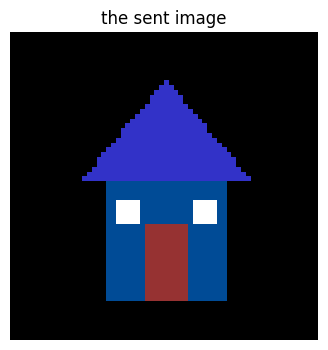

In [95]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create a blank low-resolution image (64x64 pixels)
img = np.zeros((64, 64, 3), dtype=np.uint8)

# Draw the house body (rectangle)
cv2.rectangle(img, (20, 30), (44, 55), (150, 75, 0), -1)  # Brownish color

# Draw the roof (triangle)
pts = np.array([[15, 30], [32, 10], [49, 30]], np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(img, [pts], (200, 50, 50))  # Reddish roof

# Draw the door (smaller rectangle)
cv2.rectangle(img, (28, 40), (36, 55), (50, 50, 150), -1)  # Dark blue door

# Draw windows (small squares)
cv2.rectangle(img, (22, 35), (26, 39), (255, 255, 255), -1)  # White window left
cv2.rectangle(img, (38, 35), (42, 39), (255, 255, 255), -1)  # White window right

# Convert BGR to RGB for displaying in Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show the image
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb, interpolation='nearest')
plt.axis('off')
plt.title("the sent image")
plt.show()


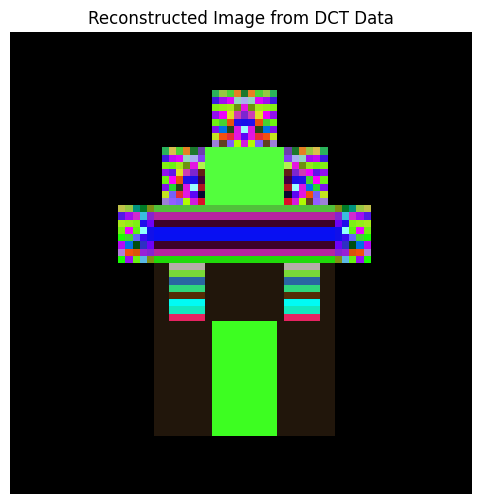

In [96]:


image=img
num_blocks_per_row = image.shape[0] // 8  # Since image is 32x32, this is 4x4 blocks
dct_blocks = np.zeros_like(image)

for i in range(num_blocks_per_row):
    for j in range(num_blocks_per_row):
        block = image[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')  # 2D DCT
        dct_blocks[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8] = dct_block

reconstructed_image = np.zeros_like(image)

for i in range(num_blocks_per_row):
    for j in range(num_blocks_per_row):
        block = dct_blocks[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8]
        idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')  # 2D IDCT
        reconstructed_image[i * 8: (i + 1) * 8, j * 8: (j + 1) * 8] = idct_block

reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image, cmap='gray', interpolation='nearest')
plt.title("Reconstructed Image from DCT Data")
plt.axis('off')
plt.show()
